**Task 1** 
***
* Download the monthly natural gas price data. Each point in the data set corresponds to the purchase price of natural gas at the end of a month, from 31st October 2020 to 30th September 2024.
* Analyze the data to estimate the purchase price of gas at any date in the past and extrapolate it for one year into the future.

   
Objective: The code should take a date as input and return a price estimate.

***
    
Given the characteristics of the data (non-stationary, positive linear trend, yearly seasonality), I have two options:
* Triple Exponential Smoothing (also known as Holt-Winter's model) - used to forecast data with seasonality and trend. Since I have monthly granularity, I need to forecast 12 data points, and this means this model will be appropriate since it is used for short to medium-term forecasts.
* Sarima Model - is used to forecast data with seasonality and trend, and also because the statistical properties like mean and variance change over time.


I will apply both to see the forecasting accuracy using RMSE (Root Mean Square Error).
The lower this value, the better the model. Triple Exponential Smoothing performs better


**Task 2**
***

Write a script that can be used to price the contract.
You need to create a prototype pricing model.

You should write a function that can use the data you created previously (output of the forecasting model) to price the contract. The client may want to choose multiple dates to inject and withdraw a set amount of gas, so your approach should generalize the explanation from before. Consider all the cash flows involved in the product.

The input parameters that should be taken into account for pricing are:

* Injection dates. 
* Withdrawal dates.
* The prices at which the commodity can be purchased/sold on those dates.
* The rate at which the gas can be injected/withdrawn.
* The maximum volume that can be stored.
* Storage costs.
  
Write a function that takes these inputs and gives back the value of the contract. You can assume there is no transport delay and that interest rates are zero. Market holidays, weekends, and bank holidays need not be accounted for. Test your code by selecting a few sample inputs.

The pricing model is at the end of the notebook, please run all cells before using it.


### Import data and libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.graph_objects as go
import matplotlib as mpl
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from math import sqrt
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# Import data
dataset = pd.read_csv('Nat_Gas.csv')
dataset.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [3]:
# Check data types
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Dates   48 non-null     object 
 1   Prices  48 non-null     float64
dtypes: float64(1), object(1)
memory usage: 900.0+ bytes


In [4]:
# Convert the 'Dates' column to a datetime type
dataset['Dates'] = pd.to_datetime(dataset['Dates'], format='%m/%d/%y')

In [5]:
# Double check result
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Dates   48 non-null     datetime64[ns]
 1   Prices  48 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 900.0 bytes


In [6]:
dataset.head()

,Dates,Prices
0,2020-10-31,10.1
1,2020-11-30,10.3
2,2020-12-31,11.0
3,2021-01-31,10.9
4,2021-02-28,10.9


In [7]:
# Set 'Dates' column as index
dataset.set_index('Dates', inplace=True)

In [8]:
# Since I have time series data I want to visualise them so see if there are any pattern, outliears and also  
# before doing a seasonall decomposing I want to understand whether the seasonality shows multiplicative or additive behavior

<Axes: xlabel='Dates'>

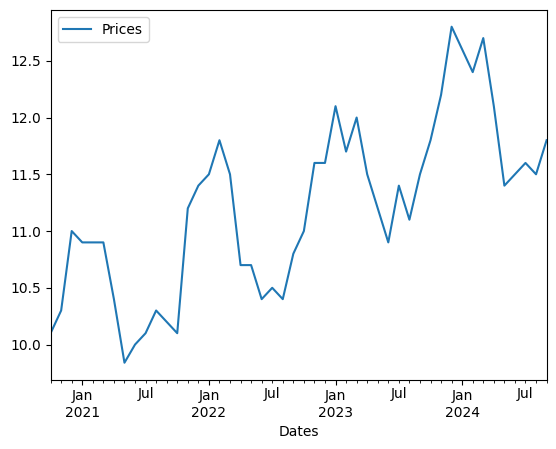

In [9]:
dataset.plot()

In [10]:
# From the plot I can observe a positive linear trend with an addittive seasonality

In [11]:
# Ho have an idea of the data I want to see mean and variance of data to understand if the data is stationary. 
# Later I will run the Augmented Dickey-Fuller test to verify if the data are stationary

<Axes: xlabel='Dates'>

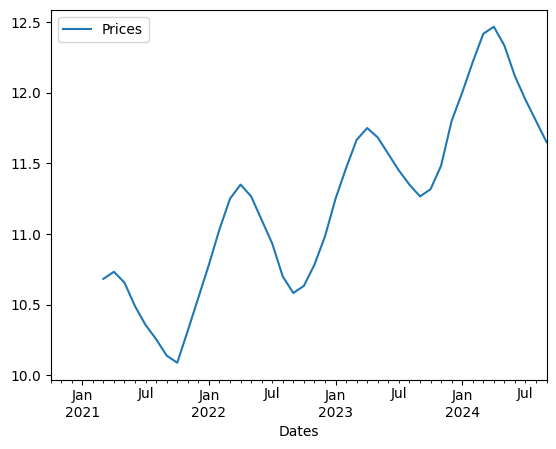

In [12]:
dataset.rolling(window=6).mean().plot()
# Already from this plot I can see that the data is not stationary since the mean is varying over different time periods

In [13]:
# I want to know more about the data so I'm going to display basic statistics. 
dataset.describe()

,Prices
count,48.000000
mean,11.207083
std,0.757897
min,9.840000
25%,10.650000
50%,11.300000
75%,11.625000
max,12.800000


In [14]:
dataset.skew()

Prices    0.126365
dtype: float64

In [15]:
dataset.kurtosis()

Prices   -0.665523
dtype: float64

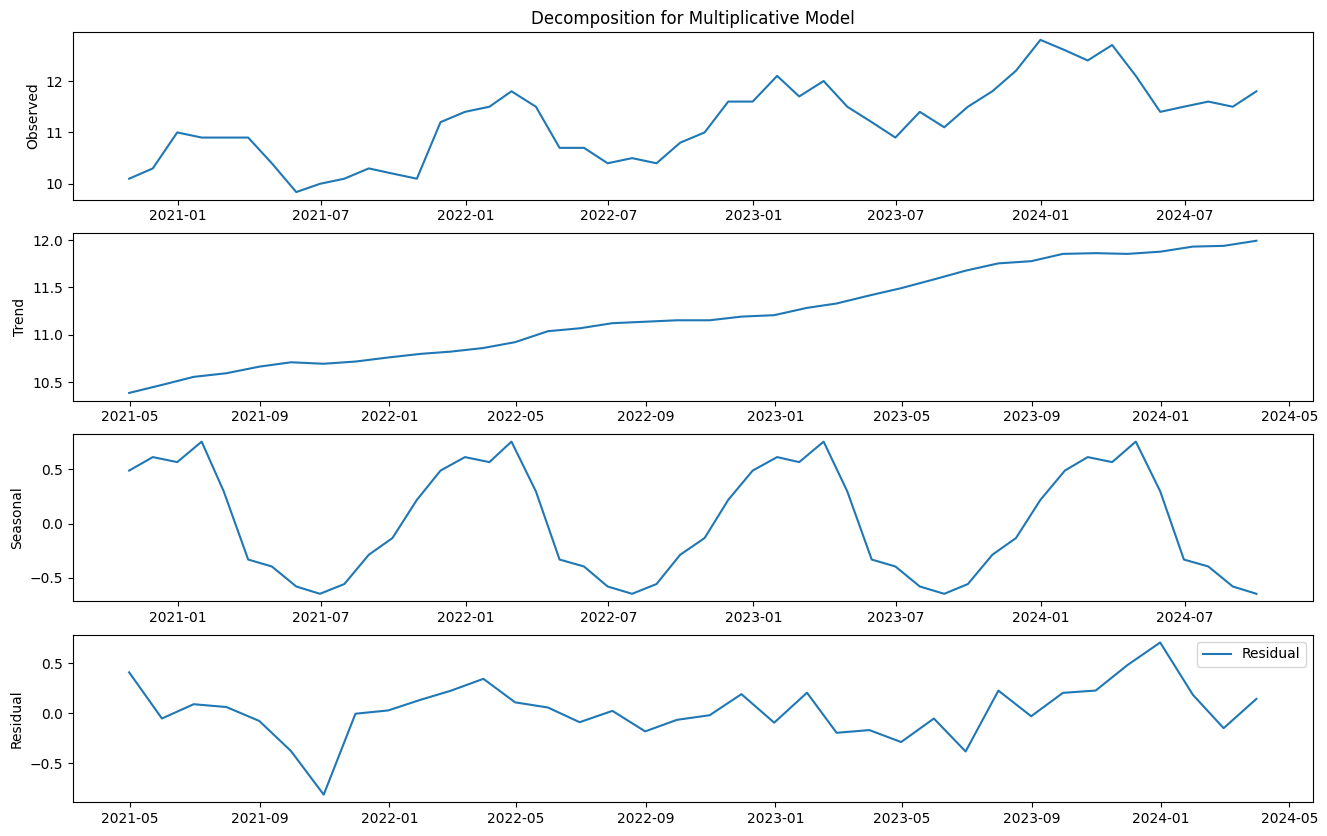

In [16]:
decomposed_gas_price = seasonal_decompose(
    dataset 
    , period=13
    , model='additive'
)

fig, ax = plt.subplots(4, 1, figsize=(16, 10))
ax[0].plot(decomposed_gas_price.observed)
ax[0].set_ylabel('Observed')
ax[0].set_title('Decomposition for Multiplicative Model')

ax[1].plot(decomposed_gas_price.trend)
ax[1].set_ylabel('Trend')

ax[2].plot(decomposed_gas_price.seasonal, label='Seasonal')
ax[2].set_ylabel('Seasonal')

ax[3].plot(decomposed_gas_price.resid, label='Residual')
ax[3].set_ylabel('Residual')

plt.legend()
plt.show()

In [17]:
# Augmented Dickey-Fuller  unit root test
def ADF_test(data):
    """
    Perform Augmented Dickey-Fuller Test
    The number of considered lags is automatically selected based 
    on the Akaike Information Criterion (AIC)
    Ho = Null Hypothesis -> The data are not stationary
    H1 = Alternate Hypotesis -> The data are stationary
    """
    result = adfuller(data, autolag='AIC')
    print(f'ADF Statistic:{result[0]}')
    print (f'P-value: {result[1]}')
    print('Critical Values:')
    for x, y in result[4].items():
        print(f'{x}:{y}')
    if result[1] > 0.05:
        print('We accept the Null Hypotesis. Data are not stationary!')
    else:
        print('We accept the Alternate Hypotesis. Data are Stationary!')

In [18]:
ADF_test(dataset)

ADF Statistic:0.21807686169999455
P-value: 0.973257438844869
Critical Values:
1%:-3.6209175221605827
5%:-2.9435394610388332
10%:-2.6104002410518627
We accept the Null Hypotesis. Data are not stationary!


In [19]:
# Find the optimal number of differencing
number_of_diff = ndiffs(dataset, test = 'adf')
print(f'Number of differencing: {number_of_diff}')

Number of differencing: 0


In [20]:
# I need to take the 12th difference for monthly data
first_order_diff = dataset.diff(12).dropna()

<Axes: xlabel='Dates'>

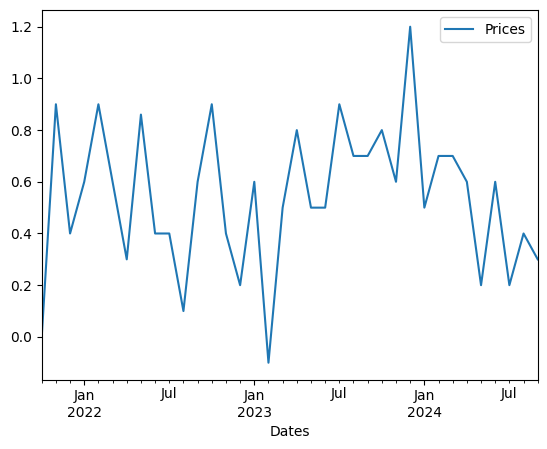

In [21]:
first_order_diff.plot()

In [22]:
ADF_test(first_order_diff)

ADF Statistic:-6.338337757875165
P-value: 2.7945314748502356e-08
Critical Values:
1%:-3.6327426647230316
5%:-2.9485102040816327
10%:-2.6130173469387756
We accept the Alternate Hypotesis. Data are Stationary!


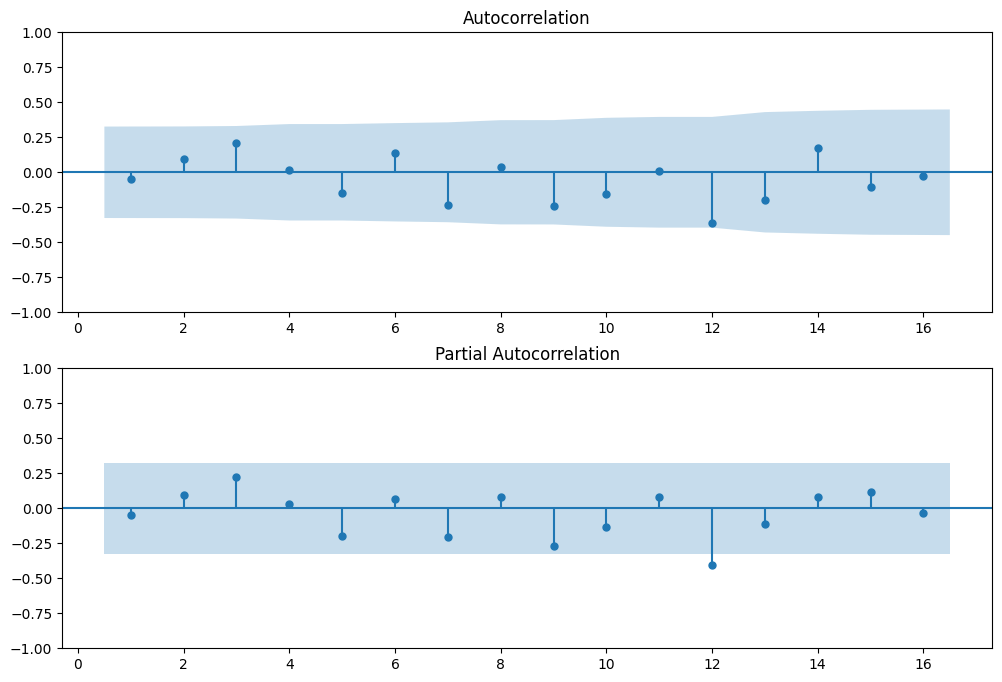

In [23]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(first_order_diff, zero=False, ax=ax[0])
plot_pacf(first_order_diff, zero=False, ax=ax[1])
plt.show()

In [24]:
#first_order_diff
split = int(len(dataset) * 0.93)
train_data = dataset.iloc[:split]
test_data = dataset.iloc[split:]

In [25]:
# Start_p -> the order of the auto-regressive (“AR”) model
# Start_q-> the starting value of q, the order of the moving-average (“MA”) model.
# m -> the number of periods in each season
model = auto_arima(
    train_data, start_p=1,
    start_q=1, max_p=12, 
    max_q=12, m=12,
    start_P=0, seasonal=True,
    #d=1, D=1,
    trace=True, error_action='ignore',
    test='adf', information_criterion='aic',
    suppress_warnings=True
)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(0,2,0)(0,1,0)[12]             : AIC=64.382, Time=0.03 sec
 ARIMA(1,2,0)(1,1,0)[12]             : AIC=50.796, Time=0.08 sec
 ARIMA(0,2,1)(0,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(1,2,0)(0,1,0)[12]             : AIC=52.336, Time=0.03 sec
 ARIMA(1,2,0)(2,1,0)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(1,2,0)(1,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(1,2,0)(0,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(1,2,0)(2,1,1)[12]             : AIC=45.575, Time=0.39 sec
 ARIMA(1,2,0)(2,1,2)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(1,2,0)(1,1,2)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(0,2,0)(2,1,1)[12]             : AIC=56.178, Time=0.29 sec
 ARIMA(2,2,0)(2,1,1)[12]             : AIC=34.934, Time=0.90 sec
 ARIMA(2,2,0)(1,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(2,2,0)(2,1,0)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(2,

In [26]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   44
Model:             SARIMAX(0, 2, 2)x(2, 1, [], 12)   Log Likelihood                  -3.641
Date:                             Fri, 22 Dec 2023   AIC                             17.282
Time:                                     10:38:32   BIC                             24.288
Sample:                                 10-31-2020   HQIC                            19.523
                                      - 05-31-2024                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.7421      0.161    -10.827      0.000      -2.057      -1.427
ma.L2          0.7801      0.172      4.539      0.000       0.443       1.117
ar.S.L12      -0.8547      0.138     -6.200      0.000      -1.125      -0.585
ar.S.L24      -0.8865      0.124     -7.145      0.000      -1.130      -0.643
sigma2         0.0173      0.017      1.020      0.308      -0.016       0.051
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 2.42
Prob(Q):                              0.83   Prob(JB):                         0.30
Heteroskedasticity (H):               0.78   Skew:                            -0.26
Prob(H) (two-sided):                  0.70   Kurtosis:                         1.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

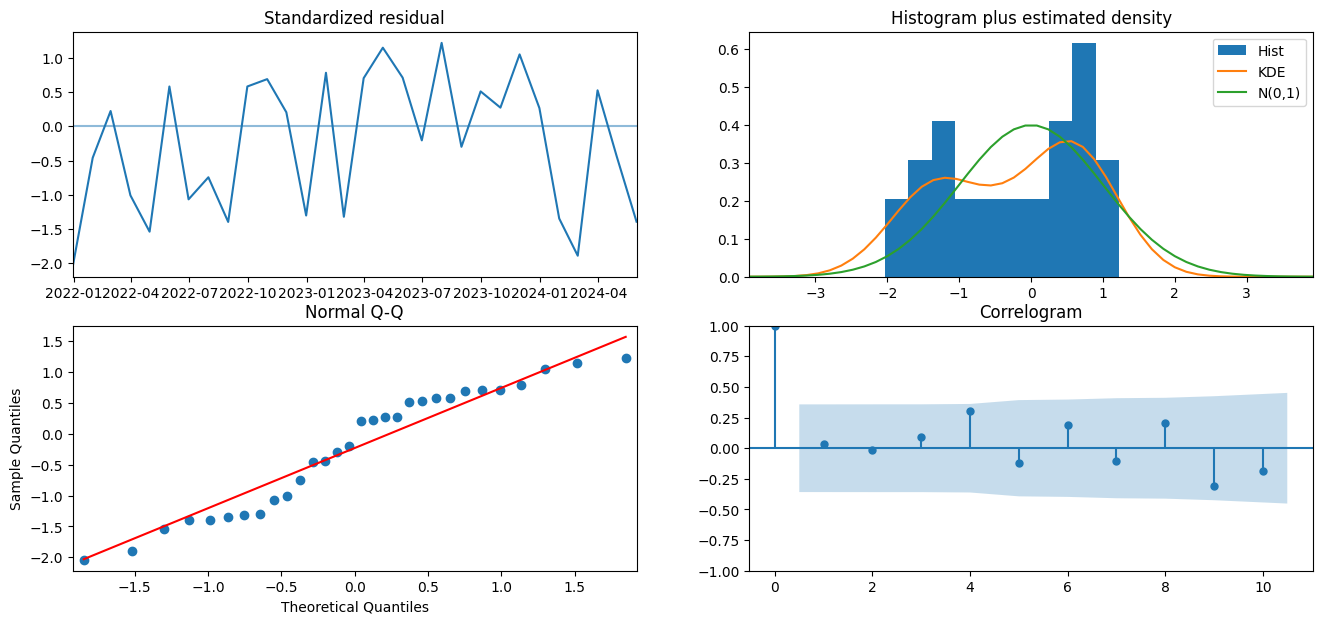

In [27]:
# Residuals to check their normality 
output = model.plot_diagnostics(figsize=(16, 7))
# correlogram tells us that there is no any pattern left in the residuals, so this is just noise


In [28]:
test_data

,Prices
Dates,
2024-06-30,11.5
2024-07-31,11.6
2024-08-31,11.5
2024-09-30,11.8


In [29]:
auto_arima_fitted = model.fit(train_data)

In [30]:
auto_arima_prediction = auto_arima_fitted.predict(len(test_data)+12).to_frame(name='Prices')

In [31]:
auto_arima_prediction

,Prices
2024-06-30,11.624463
2024-07-31,11.767172
2024-08-31,11.888684
2024-09-30,11.830018
2024-10-31,11.763187
2024-11-30,12.762006
2024-12-31,13.011077
2025-01-31,13.039379
2025-02-28,13.273612
2025-03-31,13.026293


In [32]:
auto_arima_rmse = sqrt(mean_squared_error(test_data, auto_arima_prediction.iloc[:len(test_data), :]))
print('RMSE: ', auto_arima_rmse)

RMSE:  0.2210281372441273


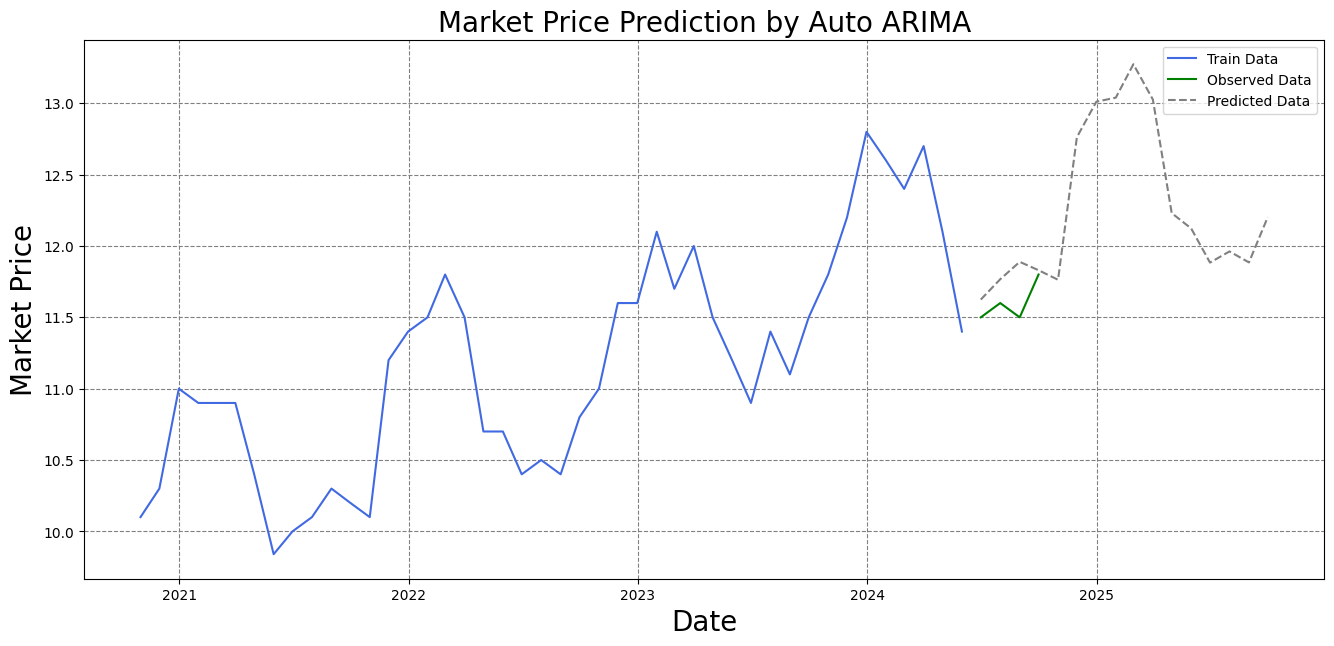

In [33]:
plt.figure(figsize=(16, 7))
plt.plot(train_data, c='royalblue')
plt.plot(test_data, c='green', ls='-')
plt.plot(auto_arima_prediction, c='grey', ls='--')
plt.xlabel('Date', size=20)
plt.ylabel('Market Price', size=20)
plt.title('Market Price Prediction by Auto ARIMA', size=20)
plt.legend(['Train Data', 'Observed Data', 'Predicted Data'])
plt.grid(linestyle='--', c='grey')

### Lets try triple exponencial smoothing

In [34]:
dataset.tail()

,Prices
Dates,
2024-05-31,11.4
2024-06-30,11.5
2024-07-31,11.6
2024-08-31,11.5
2024-09-30,11.8


In [35]:
# Devide the dataset to train (data used to train the model) and test dataset (used to validate the model)
split = int(len(dataset) * 0.80)
train_data_es = dataset.iloc[:split]
test_data_es = dataset.iloc[split:]

In [36]:
seasonal_periods = 12
# Holt-Winter's model with exponential trend
hw_1 = ExponentialSmoothing(
    train_data_es, trend='add',
    seasonal='add', seasonal_periods=seasonal_periods,
    damped_trend=False, freq='M').fit()

In [37]:
# visualiss model's parameters
hw_1.params

{'smoothing_level': 1.4901161193847656e-08,
 'smoothing_trend': 7.581140103582096e-10,
 'smoothing_seasonal': 2.3920833869386816e-16,
 'damping_trend': nan,
 'initial_level': 10.111306898455306,
 'initial_trend': 0.04586091397548479,
 'initial_seasons': array([-0.23266171,  0.29648082,  0.53414924,  0.65492615,  0.5756777 ,
         0.52981948, -0.1160418 , -0.44854828, -0.64103006, -0.45359093,
        -0.56605889, -0.37860026]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [38]:
hw_forecast_1 = hw_1.forecast(len(test_data_es) + 12)

In [39]:
hw_forecast_1 = hw_forecast_1.to_frame(name='Prices')

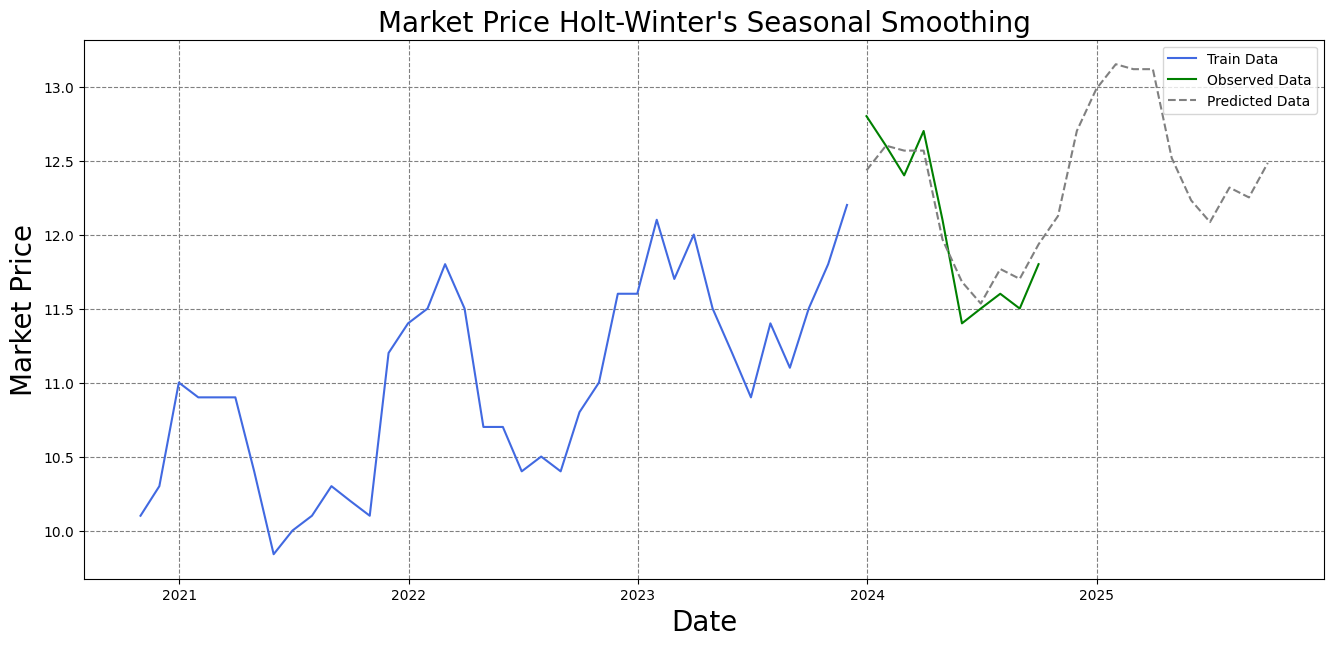

In [40]:
plt.figure(figsize=(16, 7))
plt.plot(train_data_es, c='royalblue')
plt.plot(test_data_es, c='green', ls='-')
plt.plot(hw_forecast_1, c='grey', ls='--')
plt.xlabel('Date', size=20)
plt.ylabel('Market Price', size=20)
plt.title("Market Price Holt-Winter's Seasonal Smoothing", size=20)
plt.legend(['Train Data', 'Observed Data', 'Predicted Data'])
plt.grid(linestyle='--', c='grey')

In [41]:
rmse_triple_exp_smoothing = np.sqrt(mean_squared_error(test_data_es, hw_forecast_1.iloc[:-12]))

print(f'Triple Exponential Smoothing RMSE: {rmse_triple_exp_smoothing}')

Triple Exponential Smoothing RMSE: 0.1906050886369008


In [42]:
df = pd.concat([dataset, hw_forecast_1.iloc[len(test_data):, :]])

In [43]:
hw_1.params

{'smoothing_level': 1.4901161193847656e-08,
 'smoothing_trend': 7.581140103582096e-10,
 'smoothing_seasonal': 2.3920833869386816e-16,
 'damping_trend': nan,
 'initial_level': 10.111306898455306,
 'initial_trend': 0.04586091397548479,
 'initial_seasons': array([-0.23266171,  0.29648082,  0.53414924,  0.65492615,  0.5756777 ,
         0.52981948, -0.1160418 , -0.44854828, -0.64103006, -0.45359093,
        -0.56605889, -0.37860026]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [44]:
alpha = hw_1.params['smoothing_level']
beta = hw_1.params['smoothing_trend']
gamma = hw_1.params['smoothing_seasonal']


## Enter date to get forecasted price

In [45]:
def forecast_price():
    user_date_input = input("Forecast starts from '2024-10-31'.Enter a end month date in 'YYYY-MM-DD' format: ")
    return df.loc[user_date_input, :]

In [ ]:
forecast_price()

# Pricing Model

In [ ]:
def pricing_model(*, units=1000000, purchase_date = '2023-06-30', sell_date='2024-01-31', storage_cost_per_month_1m_units = 20000, max_capacity_units = 3000000, inj_withdr_cost_per_1mil_units = 10000, transport_cost_one_way = 1000, pricing_dataframe):
   
    if units <= max_capacity_units:
        number_of_months = int((datetime.strptime(sell_date, "%Y-%m-%d").year - datetime.strptime(purchase_date, "%Y-%m-%d").year) * 12 
                               + (datetime.strptime(sell_date, "%Y-%m-%d").month - datetime.strptime(purchase_date, "%Y-%m-%d").month))
        # Dataset with Pricing
        df = pricing_dataframe
        # Total revenue 
        total_revenue = units * df.loc[sell_date, 'Prices']
        # Total costs based on months
        
        # Initial cost of purchase -> fixed costs
        fixed_costs = (units * df.loc[purchase_date, 'Prices']) + (transport_cost_one_way * 2)
        # Variable costs based on number of units purchased
        total_cost_for_storage = (storage_cost_per_month_1m_units / 1000000) * units * number_of_months
        inj_withdr_cost = (inj_withdr_cost_per_1mil_units / 1000000) * units
        
        
        variable_cost = total_cost_for_storage + inj_withdr_cost
        total_cost = fixed_costs + variable_cost
        
        revenue_loss = {'Revenue': 0.00, 'Loss': 0.00}
        
        if total_revenue > total_cost:
            profit = total_revenue - total_cost
            revenue_loss['Revenue'] = profit
        elif total_revenue < total_cost:
            loss = total_revenue - total_cost
            revenue_loss['Loss'] = loss
        elif total_revenue == total_cost:
            neutral = total_revenue - total_cost
        result = pd.DataFrame(revenue_loss, index=[1]).T.rename(columns={1: '£ Value'})
    
    else:
        result = 'Order is out of capacity!'
    return result
    

In [ ]:
pricing_model(pricing_dataframe=df)